<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Construcción y Comparación de Modelos de Clasificación

El objetivo de esta práctica es construir múltiples modelos de clasificación para predecir la probabilidad de que una transacción sea fraudulenta. Además de implementar los modelos, deberás analizar y comparar las métricas obtenidas para seleccionar el modelo que mejor se ajuste al problema. En este laboratorio deberás: 



- Entrenar al menos tres modelos diferentes de clasificación, como:

   - **Regresión logística**

   - **Árboles de decisión**

   - **Bosques aleatorios**

   - etc.


- Obtener las siguientes métricas para cada modelo:

   - Precisión

   - Recall (Sensibilidad)

   - F1-Score

   - Área bajo la curva ROC (AUC-ROC)

   - Matriz de confusión

   - Accuracy

- Visualizar y comparar estas métricas en gráficos claros y explicativos.


- Analizar las métricas de rendimiento de cada modelo.

- Justificar la selección del modelo más adecuado en función del equilibrio entre precisión y recall, así como la interpretación del área bajo la curva ROC.


In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd

from src.support_logistic import * 
from src.support_models import *

import shap

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [55]:
df = pd.read_pickle("datos/prepped_data.pkl")

In [56]:
X = df.drop(columns = "is_fraudulent")
y = df["is_fraudulent"]

Vamos a definir cada uno de los diccionarios de parámetros por los que harán combinaciones los gridsearch de cada uno de los tipos de modelos.

In [57]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

parametros_dt = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

parametros_rf = {
            'n_estimators' : [10,20,30,40],
            'max_depth': [5, 10, 15],
            'min_samples_split': [8, 10, 15, 20],
            'min_samples_leaf': [6, 8, 10, 15, 20],
            'max_leaf_nodes': [10, 15, 20, 25]
}

parametros_gb = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_split': [3,4,7],
    'min_samples_leaf': [3,4,7],
    'max_leaf_nodes': [6,10,12]
}

parametros_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}



Inicializamos la clase de clasificadores.

In [58]:
model = ClassificationModel(X, y, random_state=42)

Y ahora vamos a fittear para cada uno de ellos:

In [59]:
print("Training Regresión Logística\n")
start_time = time.time()
logistic = model.train("logistic", params=parametros_logistic, scoring="recall", verbose = 1)
print()
print("Time:", time.time() - start_time)
print()
print(logistic)
print("----"*20)

Training Regresión Logística

Fitting 5 folds for each of 43 candidates, totalling 215 fits

Time: 5.283986568450928

LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')
--------------------------------------------------------------------------------


In [60]:
print("Training Árbol de Decisión\n")
start_time = time.time()
decisiontree = model.train("decision_tree", params = parametros_dt, scoring="recall", verbose = 1)
print()
print("Time:", time.time() - start_time)
print()
print(decisiontree)
print("----"*20)

Training Árbol de Decisión

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

Time: 17.24379301071167

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=6,
                       min_samples_split=6, random_state=42)
--------------------------------------------------------------------------------


In [61]:
print("Training Random Forest\n")
start_time = time.time()
randomforest = model.train("random_forest", params = parametros_rf, scoring="recall", verbose = 1)
print()
print("Time:", time.time() - start_time)
print()
print(randomforest)
print("----"*20)

Training Random Forest

Fitting 5 folds for each of 960 candidates, totalling 4800 fits

Time: 99.11039543151855

RandomForestClassifier(max_depth=15, max_leaf_nodes=20, min_samples_leaf=6,
                       min_samples_split=20, n_estimators=40, n_jobs=-1,
                       random_state=42)
--------------------------------------------------------------------------------


In [62]:
print("Training Gradient Boosting\n")
start_time = time.time()
gradientboost = model.train("gradient_boosting", params = parametros_gb, scoring="recall", verbose = 1)
print()
print("Time:", time.time() - start_time)
print()
print(gradientboost)
print("----"*20)

Training Gradient Boosting

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Time: 76.4487247467041

GradientBoostingClassifier(max_depth=5, max_leaf_nodes=6, min_samples_leaf=7,
                           min_samples_split=3, n_estimators=50,
                           random_state=42)
--------------------------------------------------------------------------------


In [63]:
print("Training XGBoost\n")
start_time = time.time()
xgboost = model.train("xgboost", params = parametros_xgb, scoring="recall", verbose = 1)
print()
print("Time:", time.time() - start_time)
print()
print(xgboost)

Training XGBoost

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Time: 25.057996034622192

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


Podemos visualizar las matrices de confusión de cada uno de los modelos.

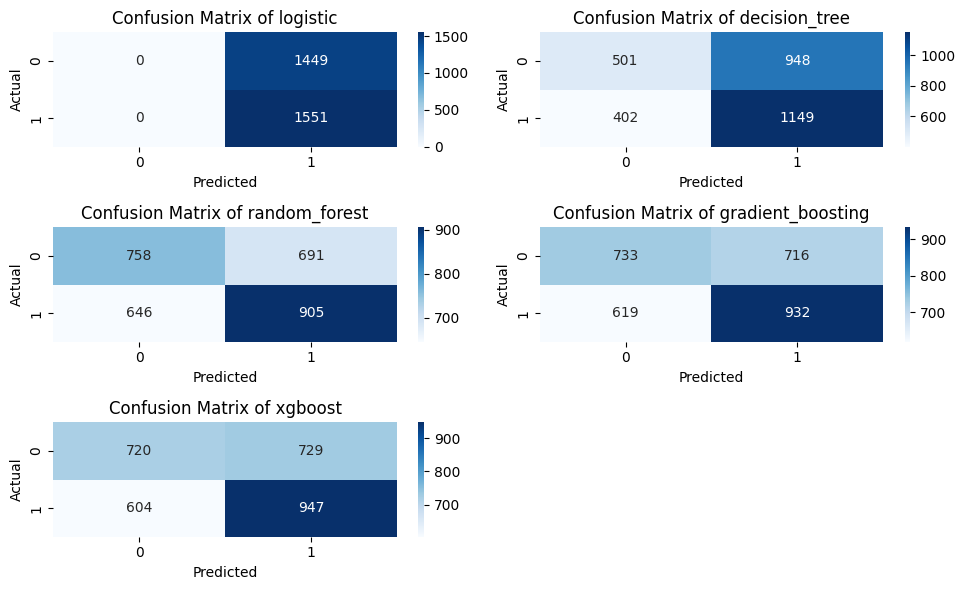

In [64]:
model.plot_confusion_matrix()

Apreciamos que al haber priorizado recall, se nos minimizan los falsos negativos, es decir que tenemos pocas instancias de que un registro sea fraude pero nuestro modelo lo tome como no fraude. 

Sin embargo, vemos que el modelo de regresión logística se prioriza tanto el recall que el modelo clasifica todos los valores como 1, por lo que ningún valor será ni TN ni FN.

Además, aunque es cierto que el modelo de decision tree es la que más minimiza los falsos negativos, genera bastantes falsos positivos. Mientras tanto, el resto de modelos equilibra un poco más entre FN y FP. Todo vendrá dado por cuánta sea la prioridad que le demos a esta minimización.

Otra visualización útil puede ser la curva ROC para cada modelo. Esta nos dará información de lo alejado que está nuestro modelo de uno con predicciones provenientes del azar.

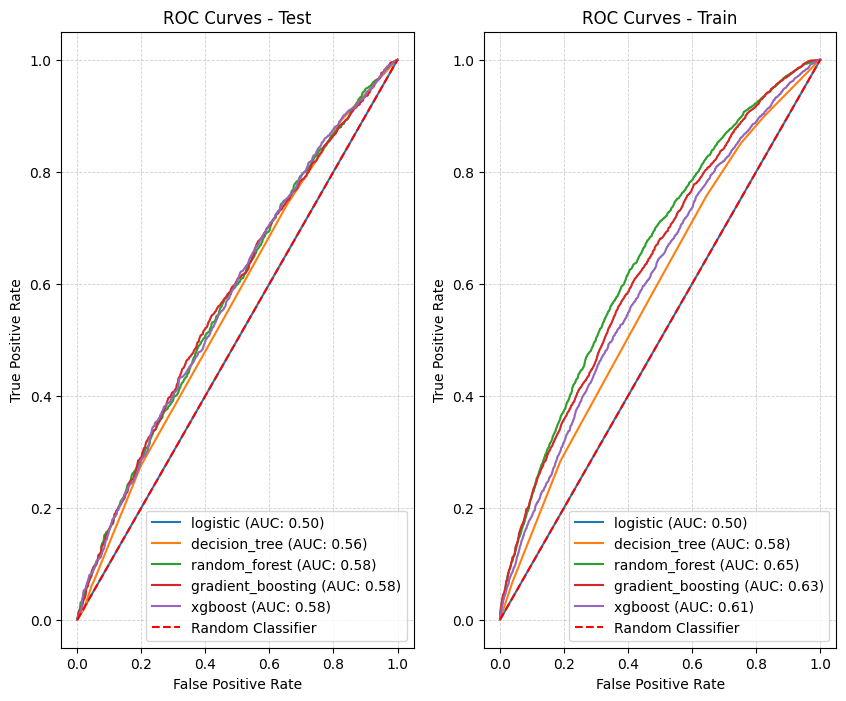

In [65]:
model.plot_roc_curves()

Vemos que con los datos de train obtenemos mejores modelos que en test, indicando un overfitting. Sin embargo, tampoco son modelos lo suficientemente buenos como para fiarnos de sus predicciones a nivel de usuario. 

En el train, el mejor modelo es el random forest, mientras que para test ninguno predomina del todo (siempre en cuanto a AUC). Sí que está claro que, como hemos mencionado previamente, el logistic regressor no nos vale para este caso.

Por último echemos un vistazo a las métricas que obtenemos en cada modelo.

In [66]:
df_metrics = pd.DataFrame()
for k in model.resultados.keys():
    df_it = model.resultados[k]["metrics"]
    df_it["method"] = k
    df_metrics = pd.concat([df_metrics, df_it])

df_resultados_colores = df_metrics.copy()
df_resultados_colores.reset_index(inplace = True)
df_resultados_colores = df_resultados_colores.style.apply(color_filas_por_modelo, axis=1)
df_resultados_colores

,index,precision,accuracy,recall,f1_score,kappa,auc,time,n_jobs,method
0,train,0.502429,0.502429,1.000000,0.668822,0.000000,0.500000,0.003961,None,logistic
1,test,0.517000,0.517000,1.000000,0.681608,0.000000,0.500000,0.003961,None,logistic
2,train,0.542542,0.557143,0.756042,0.631742,0.112560,0.581477,0.003011,12,decision_tree
3,test,0.547926,0.550000,0.740812,0.629934,0.087654,0.562828,0.003011,12,decision_tree
4,train,0.602203,0.606286,0.637475,0.619337,0.212328,0.650114,0.033920,-1,random_forest
5,test,0.567043,0.554333,0.583495,0.575151,0.106723,0.577004,0.033920,-1,random_forest
6,train,0.583507,0.589000,0.635769,0.608518,0.177621,0.634708,0.008999,12,gradient_boosting
7,test,0.565534,0.555000,0.600903,0.582682,0.107004,0.578867,0.008999,12,gradient_boosting
8,train,0.567929,0.574429,0.639465,0.601578,0.148313,0.606947,0.010005,None,xgboost
9,test,0.565036,0.555667,0.610574,0.586923,0.107774,0.577843,0.010005,None,xgboost


- En la regresión logística vemos muy claramente lo explicado anteriormente, se maximiza recall pero a costo de que todos los valores se convierten en positivo. 

- Si quisieramos priorizar la minimización de los FN, escogeremos aquel con mayor recall, en este caso siendo decision tree, aunque vemos que sacrificamos más en precision y accuracy (falsos positivos y proporción de aciertos totales). También tenemos un kappa bastante bajo, lo cual indicaría que existen predicciones acertadas de este modelo que son de procedencia del azar. Convendría aumentar este valor para darnos mayor seguridad a la hora de predecir.

- Si observamos el random forest, vemos que no tenemos tan buen recall pero aumentamos nuestra precisión y accuracy. Sin embargo esto solo ocurre en el train, viendo que este modelo tiende más al overfitting, por lo que no sería el más adecuado. Este overfitting se aprecia también en el kappa, viendo una diferencia entre train y test bastante relevante.

- El gradient boosting presenta métricas similares al random forest. Sin embargo se logra reducir el overfitting, pero a costa de los valores en train, no mejorando las métricas del test. 

- El xgboost es muy similar al gradient boosting, aunque empeora aún más las métricas del train. Esto tiene como consecuencia un menor overfitting, aunque no con métricas muy favorecedoras. La principal ventaja de este modelo es la gran velocidad de computación con respecto al random forest y el gradient boosting, viendo más arriba que tarda 25 segundos con más de 1000 fitteos, comparado el 1 minuto 15 segundos del gradient boosting con 850 fitteos.

Tras este análisis, la conclusión es que los modelos más adecuados serían el decision tree o el xgboost: decision tree si la prioridad máxima es reducir el número de FN que tenemos, xgboost si priorizamos la velocidad y la mejora en kappa.